3.On a chosen timeseries dataset, forecast the trend using LSTM and GRU. Compare the
performance of these two models

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

13568290/13568290 [==============================] - 2s 0us/step


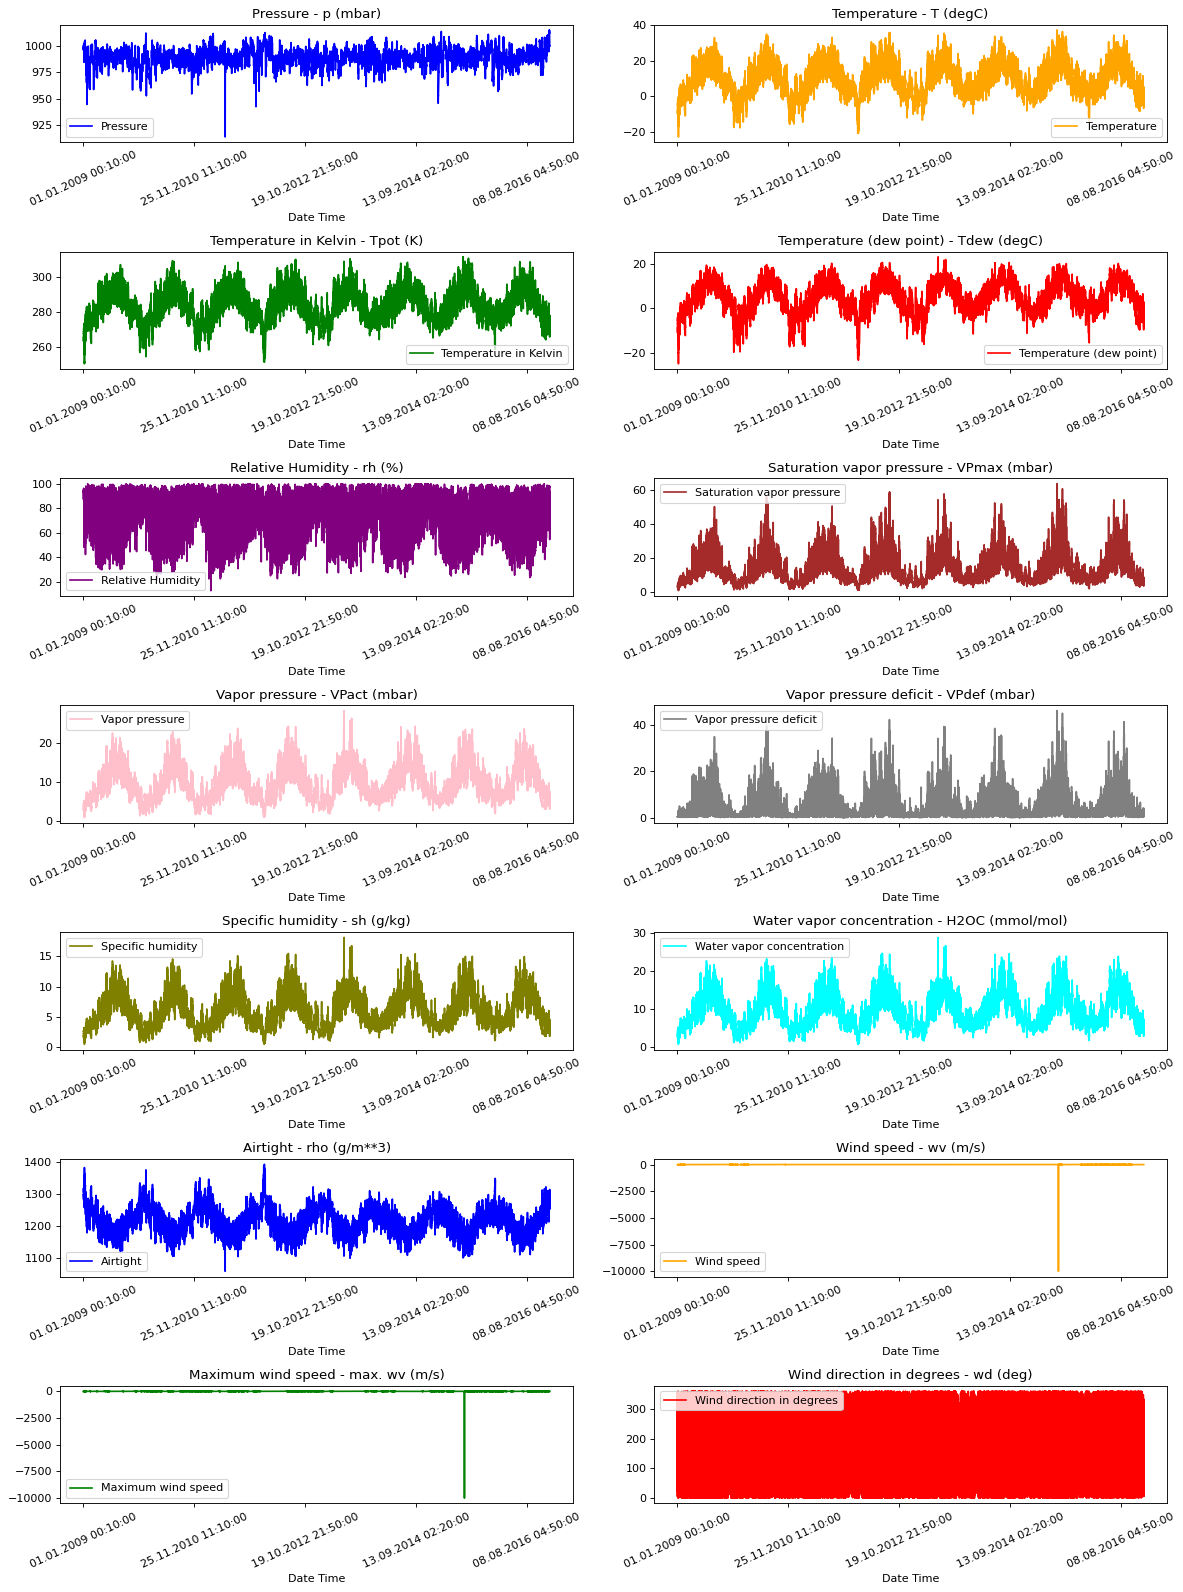

In [3]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

In [4]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [5]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [6]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

In [7]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [8]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


LSTM

In [11]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 0.2140
Epoch 1: val_loss improved from inf to 0.16211, saving model to model_checkpoint.h5
1172/1172 [==============================] - 69s 52ms/step - loss: 0.2140 - val_loss: 0.1621
Epoch 2/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.1288
Epoch 2: val_loss improved from 0.16211 to 0.14699, saving model to model_checkpoint.h5
1172/1172 [==============================] - 58s 50ms/step - loss: 0.1288 - val_loss: 0.1470
Epoch 3/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1161
Epoch 3: val_loss did not improve from 0.14699
1172/1172 [==============================] - 58s 49ms/step - loss: 0.1161 - val_loss: 0.1476
Epoch 4/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.1108
Epoch 4: val_loss did not improve from 0.14699
1172/1172 [==============================] - 58s 50ms/step - loss: 0.1108 - val_loss: 0.1483
Epoch 5/10
1172/1172 [========================

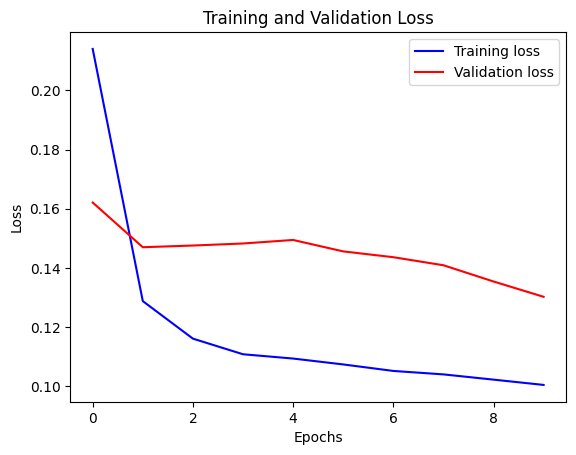

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

8/8 [==============================] - 0s 4ms/step


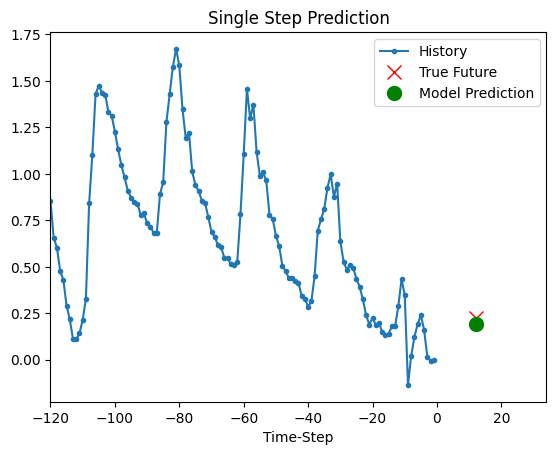

8/8 [==============================] - 0s 4ms/step


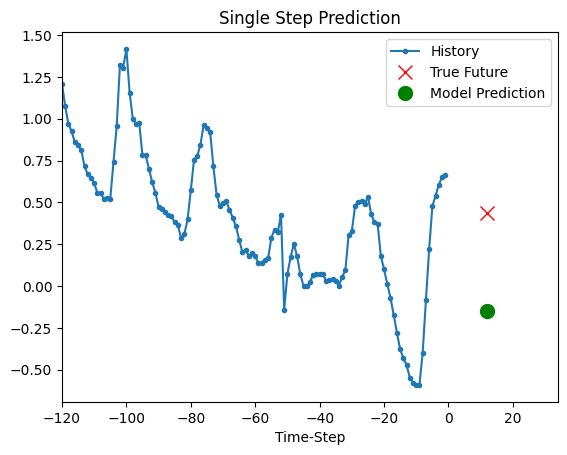

8/8 [==============================] - 0s 4ms/step


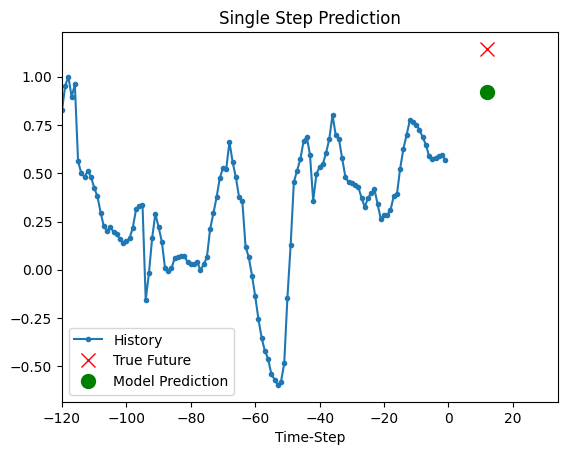

8/8 [==============================] - 0s 4ms/step


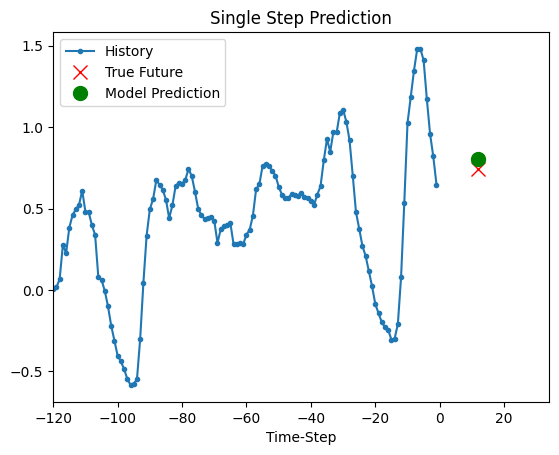

8/8 [==============================] - 0s 5ms/step


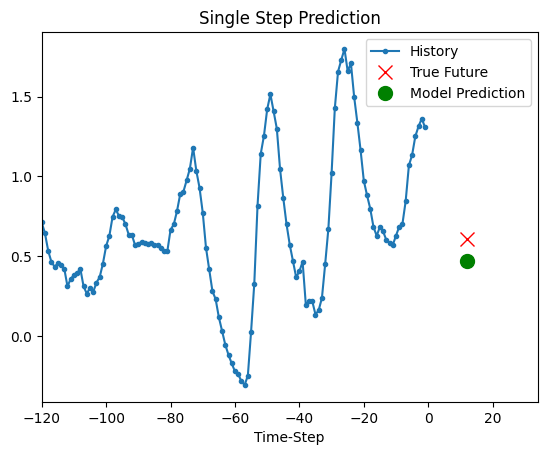

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

GRU

In [12]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
GRU_out = keras.layers.GRU(32)(inputs)
outputs = keras.layers.Dense(1)(GRU_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 gru (GRU)                   (None, 32)                3936      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


In [13]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 0.2288
Epoch 1: val_loss improved from inf to 0.20480, saving model to model_checkpoint.h5
1172/1172 [==============================] - 68s 51ms/step - loss: 0.2288 - val_loss: 0.2048
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1467
Epoch 2: val_loss improved from 0.20480 to 0.16458, saving model to model_checkpoint.h5
1172/1172 [==============================] - 56s 48ms/step - loss: 0.1467 - val_loss: 0.1646
Epoch 3/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.1232
Epoch 3: val_loss improved from 0.16458 to 0.13256, saving model to model_checkpoint.h5
1172/1172 [==============================] - 54s 46ms/step - loss: 0.1231 - val_loss: 0.1326
Epoch 4/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.1117
Epoch 4: val_loss improved from 0.13256 to 0.12638, saving model to model_checkpoint.h5
1172/1172 [==============================] - 55s 47ms/ste

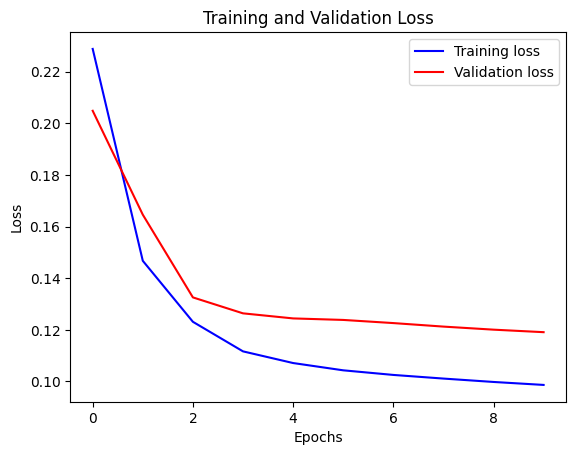

In [14]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

8/8 [==============================] - 1s 4ms/step


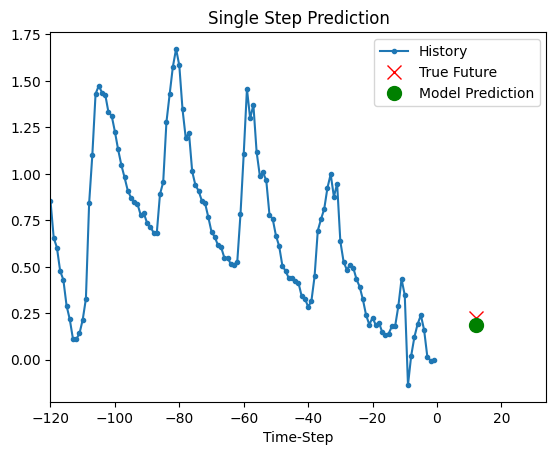

8/8 [==============================] - 0s 4ms/step


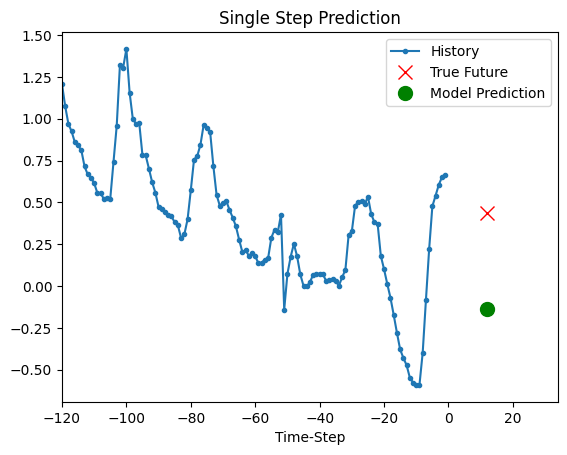

8/8 [==============================] - 0s 4ms/step


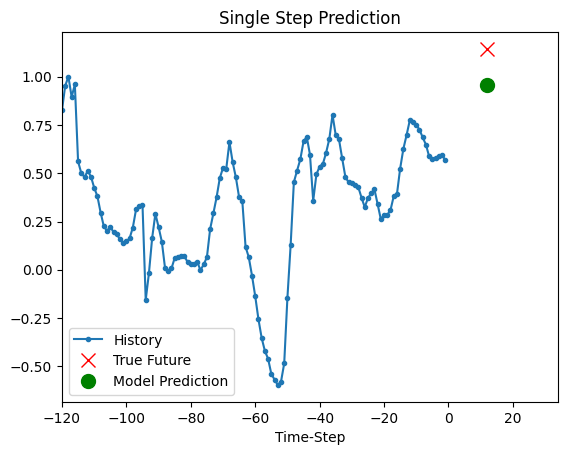

8/8 [==============================] - 0s 4ms/step


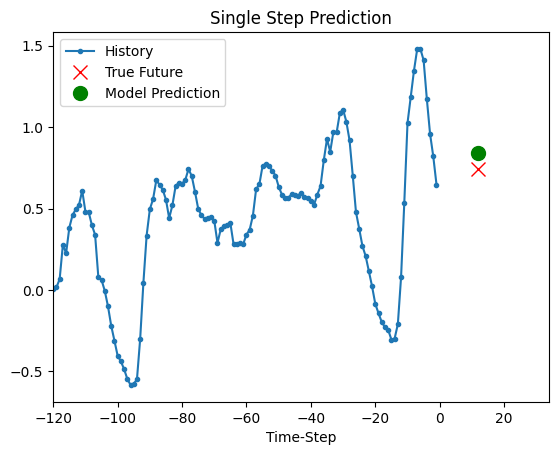

8/8 [==============================] - 0s 4ms/step


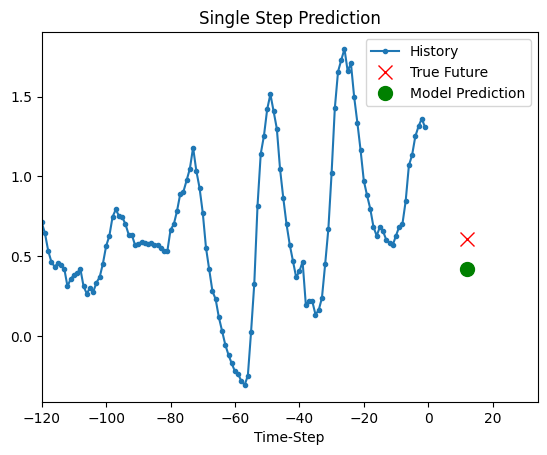

In [15]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

LSTM VS GRU
GRU comparatively seems to perform better

4. For the chosen dataset, implement autoencoder using (i) deep neural network (ii) CNN
(iii) stacked encoder

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [2]:
# Load CIFAR10 dataset
(x_train, _), (x_test, _) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [3]:
# Normalize pixel values between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [4]:
# Flatten images
x_train_flat = x_train.reshape((-1, 32 * 32 * 3))
x_test_flat = x_test.reshape((-1, 32 * 32 * 3))

(i) deep neural network

In [5]:
# Define autoencoder model
input_shape = (32 * 32 * 3,)
encoding_dim = 128

input_img = Input(shape=input_shape)
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(32 * 32 * 3, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_flat, x_train_flat, epochs=10, batch_size=128, shuffle=True)

# Evaluate the trained model
score = autoencoder.evaluate(x_test_flat, x_test_flat, verbose=0)
print('Test loss:', score)

Epoch 1/10
391/391 [==============================] - 7s 4ms/step - loss: 0.6319
Epoch 2/10
391/391 [==============================] - 2s 4ms/step - loss: 0.6072
Epoch 3/10
391/391 [==============================] - 2s 4ms/step - loss: 0.5986
Epoch 4/10
391/391 [==============================] - 2s 4ms/step - loss: 0.5934
Epoch 5/10
391/391 [==============================] - 2s 4ms/step - loss: 0.5909
Epoch 6/10
391/391 [==============================] - 2s 5ms/step - loss: 0.5897
Epoch 7/10
391/391 [==============================] - 2s 6ms/step - loss: 0.5894
Epoch 8/10
391/391 [==============================] - 2s 5ms/step - loss: 0.5892
Epoch 9/10
391/391 [==============================] - 2s 4ms/step - loss: 0.5891
Epoch 10/10
391/391 [==============================] - 2s 4ms/step - loss: 0.5892
Test loss: 0.5897290110588074


(ii) CNN

In [6]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

In [7]:

# Define autoencoder model
input_shape = (32, 32, 3)

input_img = Input(shape=input_shape)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)

autoencoder = Model(input_img, decoded)

# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=10, batch_size=128, shuffle=True)

# Evaluate the trained model
score = autoencoder.evaluate(x_test, x_test, verbose=0)
print('Test loss:', score)

Epoch 1/10
391/391 [==============================] - 9s 7ms/step - loss: 0.5781
Epoch 2/10
391/391 [==============================] - 2s 6ms/step - loss: 0.5578
Epoch 3/10
391/391 [==============================] - 2s 6ms/step - loss: 0.5557
Epoch 4/10
391/391 [==============================] - 2s 6ms/step - loss: 0.5544
Epoch 5/10
391/391 [==============================] - 3s 7ms/step - loss: 0.5526
Epoch 6/10
391/391 [==============================] - 2s 6ms/step - loss: 0.5520
Epoch 7/10
391/391 [==============================] - 2s 6ms/step - loss: 0.5517
Epoch 8/10
391/391 [==============================] - 2s 6ms/step - loss: 0.5515
Epoch 9/10
391/391 [==============================] - 2s 6ms/step - loss: 0.5513
Epoch 10/10
391/391 [==============================] - 3s 7ms/step - loss: 0.5512
Test loss: 0.5520055294036865


(iii) stacked encoder

In [8]:
# Define stacked encoder model
input_shape = (32 * 32 * 3,)
encoding_dim = 128

input_img = Input(shape=input_shape)
encoded = Dense(256, activation='relu')(input_img)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(32 * 32 * 3, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)

# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_flat, x_train_flat, epochs=10, batch_size=128, shuffle=True)

# Evaluate the trained model
score = autoencoder.evaluate(x_test_flat, x_test_flat, verbose=0)
print('Test loss:', score)

Epoch 1/10
391/391 [==============================] - 3s 5ms/step - loss: 0.6197
Epoch 2/10
391/391 [==============================] - 2s 5ms/step - loss: 0.5896
Epoch 3/10
391/391 [==============================] - 2s 5ms/step - loss: 0.5838
Epoch 4/10
391/391 [==============================] - 2s 6ms/step - loss: 0.5814
Epoch 5/10
391/391 [==============================] - 2s 5ms/step - loss: 0.5795
Epoch 6/10
391/391 [==============================] - 2s 5ms/step - loss: 0.5786
Epoch 7/10
391/391 [==============================] - 2s 5ms/step - loss: 0.5775
Epoch 8/10
391/391 [==============================] - 2s 5ms/step - loss: 0.5767
Epoch 9/10
391/391 [==============================] - 2s 5ms/step - loss: 0.5760
Epoch 10/10
391/391 [==============================] - 2s 5ms/step - loss: 0.5757
Test loss: 0.5774197578430176
